<a href="https://colab.research.google.com/github/chrisporras/graddiss/blob/main/GradientDissentersHackathon2023.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Hackathon 2023
ML for Biomedical Data Science
Team Gradient Dissenters

Members: Audrey Lee, Christian Porras, Joy Jiang

## Description

What worked for us


What didn't work for us

## Mount Google Drive
To save and access saved models

For saving and loading models 

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
save_models_dir = "/content/drive/MyDrive/ML for BDS/Hackathon - graddiss/"

## Install and load Kaggle mammography

In [ ]:
# Clone project git repo
!git clone https://github.com/chrisporras/graddiss.git

Cloning into 'graddiss'...
remote: Enumerating objects: 68, done.
remote: Counting objects: 100% (68/68), done.
remote: Compressing objects: 100% (68/68), done.
remote: Total 68 (delta 37), reused 0 (delta 0), pack-reused 0
Unpacking objects: 100% (68/68), 1.20 MiB | 1.88 MiB/s, done.


In [ ]:
# install Kaggle public api
! pip install -q kaggle
# Choose the kaggle.json file that you downloaded
! mkdir ~/.kaggle
! cp ./graddiss/kaggle.json ~/.kaggle/
# Make directory named kaggle and copy kaggle.json file there.
!chmod 600 ~/.kaggle/kaggle.json
#Change the permissions of the file.
! kaggle datasets list

ref                                                           title                                          size  lastUpdated          downloadCount  voteCount  usabilityRating  
------------------------------------------------------------  ---------------------------------------------  ----  -------------------  -------------  ---------  ---------------  
salvatorerastelli/spotify-and-youtube                         Spotify and Youtube                             9MB  2023-03-20 15:43:25           2196         90  1.0              
dgoenrique/netflix-movies-and-tv-shows                        Netflix Movies and TV Shows                     2MB  2023-03-13 18:49:00           1506         41  1.0              
rajkumarpandey02/list-of-countries-by-gdp-sector-composition  List of Countries by GDP Sector Composition     8KB  2023-03-20 04:42:10           1327         46  1.0              
datascientistanna/customers-dataset                           Shop Customer Data                    

In [ ]:
!kaggle competitions download -c mammography-image-patch-classification-2023

100% 460M/460M [00:03<00:00, 151MB/s]
100% 460M/460M [00:03<00:00, 156MB/s]


In [ ]:
# data directory
!mkdir data
# unzip data there,
!unzip mammography-image-patch-classification-2023.zip -d data

Streaming output truncated to the last 5000 lines.
  inflating: data/train_imgs/P000435.png  
  inflating: data/train_imgs/P000436.png  
  inflating: data/train_imgs/P000437.png  
  inflating: data/train_imgs/P000438.png  
  inflating: data/train_imgs/P000439.png  
  inflating: data/train_imgs/P000440.png  
  inflating: data/train_imgs/P000441.png  
  inflating: data/train_imgs/P000442.png  
  inflating: data/train_imgs/P000443.png  
  inflating: data/train_imgs/P000444.png  
  inflating: data/train_imgs/P000445.png  
  inflating: data/train_imgs/P000446.png  
  inflating: data/train_imgs/P000447.png  
  inflating: data/train_imgs/P000448.png  
  inflating: data/train_imgs/P000449.png  
  inflating: data/train_imgs/P000450.png  
  inflating: data/train_imgs/P000451.png  
  inflating: data/train_imgs/P000452.png  
  inflating: data/train_imgs/P000453.png  
  inflating: data/train_imgs/P000454.png  
  inflating: data/train_imgs/P000455.png  
  inflating: data/train_imgs/P000456.png  
  i

## Explore and prepare data

In [ ]:
# Configuration class
class Config:
    resize = False
    batch_size = 32
    numworkers = 2

In [ ]:
import os
from PIL import Image
import torchvision
from skimage import io, img_as_float32
import numpy as np
import torch
from skimage.io import imread
from skimage.util import img_as_ubyte
from skimage import exposure
import cv2

class ToTensor3D(object):
    """Convert ndarrays in sample to Tensors."""
    def __call__(self, image):
        image = img_as_float32(image)

        # The following two lines are to duplicate the grayscale image onto
        # 3 channels. That's to make the input compatible with those models
        # trained on color images. If you don't use pretrained models, you can
        # delete these two lines.
        new_shape = (3,) + image.shape
        dup_img = np.broadcast_to(image, new_shape)

        return torch.from_numpy(dup_img.copy())

class CustomImageDataset(torch.utils.data.Dataset):
    """Make a custom dataset for the mammography patches"""  
    def __init__(self, image_dir, df, transform=None, testset=False):
        # Create one iterable that can be __getitemed__
        self.image_dir = image_dir
        self.df = df
        self.transform = transform # added transform
        self.testset = testset # indicates if dataset is the test set

    def __len__(self): # Denotes the total number of samples
        # return self.df.shape[0] # orig
        return len(self.df) # try this

    def normalize(self, image):
      """
      Apply image-level normalization for pre-processing.
      For more background, read here: 
      https://towardsdatascience.com/train-a-neural-network-to-detect-breast-mri-tumors-with-pytorch-250a02be7777
      https://scikit-image.org/docs/stable/user_guide/data_types.html
      https://www.di.ubi.pt/~lfbaa/pubs/recpad2017b.pdf 
      """
      # OLD
      # image = image.astype(float) * 255. / image.max()
      # # Convert float --> uint8. This maps pixel intensities from 0 to 255
      # # Source: above and here: https://scikit-image.org/docs/stable/user_guide/data_types.html
      # image = image.astype(np.uint8)

      # NEW
      # Convert to 8-bit uint (going from [0 to 65535] to [0 to 255])
      # I read the skimage page more closely, where it cautions against using
      # astype. It calls for the below usage instead. These functions convert 
      # images to the desired dtype and properly rescale their values:
      image = img_as_ubyte(image) 

      # Histogram equalization --> poor val acc
      # image = exposure.equalize_hist(image) # skimage implementation
      # image = cv2.equalizeHist(image) # OpenCV implementation

      # Subtract image mean and divide by standard deviation --> poor val acc
      # image_mean = image.mean()
      # image_std = image.std()
      # image = (image - image_mean) / image_std

      return image

    def __getitem__(self, index): # Generates one sample of data
        
        # added this
        if torch.is_tensor(index):
          index = index.tolist()

        # Goes to image_tensor below
        image_path = os.path.join(self.image_dir, self.df.iloc[index]['img_name'])
        # image_og = Image.open(image_path)
        image_og = imread(image_path, as_gray=True) # read in png or jpg

        # Apply image-level normalization for preprocessing
        image = self.normalize(image_og)

        # Convert to 3D tensor
        t = ToTensor3D()
        image = t(image)

        if self.transform:
          image = self.transform(image)
          # image = self.transform(image_og)

        # Since the test set has no label_num, we get the image id
        if not(self.testset):
          label = torch.tensor(self.df.iloc[index]['label_num'],dtype=torch.long)
        else:
          label = self.df.iloc[index]['id'] 

        # # Resize, depending on the network ---> CAN REMOVE
        # if Config.resize:
        #     resize = torchvision.transforms.Resize(384)
        #     image = resize(image)
        
        return image, label

In [ ]:
import pandas as pd

# New numeric labels.
labels_num = {'background': 0, 'calc_ben': 1, 'calc_mal': 2, 
              'mass_ben': 3, 'mass_mal': 4}

# Read image metadata
traindf = pd.read_csv('data/train.csv') 
traindf['label_num'] = traindf['label'].map(labels_num)

testdf = pd.read_csv('data/test.csv')

# print(traindf)
# print()
# print(testdf)

In [ ]:
# Get how many in each label category
traindf.groupby(["label_num"]).count()

,id,label,img_name
label_num,,,
0,2495,2495,2495
1,1042,1042,1042
2,579,579,579
3,681,681,681
4,637,637,637


Visualize the distribution of the raw data. Notice the class imbalance such that the majority of the data is "background".

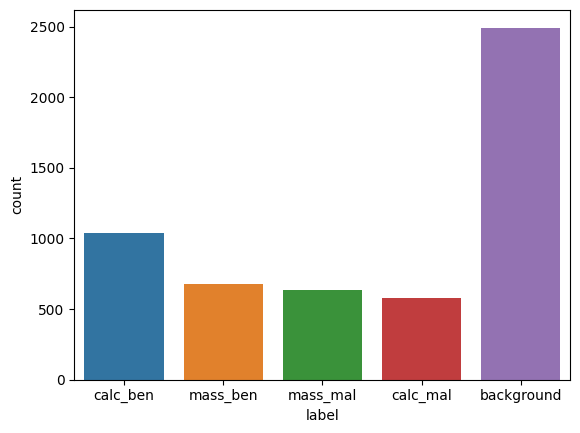

In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt

# Visualize the different classes
fig, ax = plt.subplots()
ax = sns.countplot(data=traindf,
                   x="label")


In [ ]:
# For more ease getting word labels from numerical predictions later
num_labels = {v:k for k,v in labels_num.items()}
num_labels

{0: 'background', 1: 'calc_ben', 2: 'calc_mal', 3: 'mass_ben', 4: 'mass_mal'}

Consider the data augmentation steps we would like to apply to the mammography patches. 

Here are some helpful resources:
*   https://www.kaggle.com/competitions/rsna-breast-cancer-detection/discussion/372567
*   https://www.nature.com/articles/s41598-019-48995-4#Sec2



In [ ]:
from torch.utils.data import TensorDataset, DataLoader, WeightedRandomSampler
from torchvision import datasets, transforms

# First, work with some minimal transforms
initial_transforms = transforms.Compose([
      transforms.Resize((224,224)),
      transforms.Normalize([0, 0, 0], [1, 1, 1])
      ])

# First, create the original train dataset without transforms
untransformed_train_dataset = CustomImageDataset('data/train_imgs', traindf,
                                                 transform = initial_transforms)
# Create the original val dataset, which is basically a copy of the 
# orig_train_dataset, but with a different set of transformations
untransformed_val_dataset = CustomImageDataset('data/train_imgs', traindf,
                                                 transform = initial_transforms)

# Split the orig_train_dataset into preliminary train and val datasets
train_size = int(0.9 * len(untransformed_train_dataset))
val_size = len(untransformed_train_dataset) - train_size
temp_train_dataset, temp_val_dataset = torch.utils.data.random_split(untransformed_train_dataset, 
                                                     [train_size, val_size])

# Keep track of the indices for each dataset for later
train_indices = temp_train_dataset.indices
val_indices = temp_val_dataset.indices

image_loader = DataLoader(temp_train_dataset, batch_size=Config.batch_size,
                          shuffle=False, num_workers=Config.numworkers)

def batch_mean_and_sd(loader):
    """
    Helper function to get mean and std of dataset using the dataloader.
    See: https://www.google.com/url?q=https://www.binarystudy.com/2022/04/how-to-normalize-image-dataset-inpytorch.html&sa=D&source=editors&ust=1679883727112650&usg=AOvVaw0FvYMWXTnXnGFI5RooK_pJ
    """
    cnt = 0
    fst_moment = torch.empty(3)
    snd_moment = torch.empty(3)

    for images, _ in loader:
        b, c, h, w = images.shape
        nb_pixels = b * h * w
        sum_ = torch.sum(images, dim=[0, 2, 3])
        sum_of_square = torch.sum(images ** 2,
                                  dim=[0, 2, 3])
        fst_moment = (cnt * fst_moment + sum_) / (
                      cnt + nb_pixels)
        snd_moment = (cnt * snd_moment + sum_of_square) / (
                            cnt + nb_pixels)
        cnt += nb_pixels

    mean, std = fst_moment, torch.sqrt(snd_moment - fst_moment ** 2)        
    return mean,std
  
train_ds_mean, train_ds_std = batch_mean_and_sd(image_loader)
print("mean and std: \n", train_ds_mean, train_ds_std)

mean and std: 
 tensor([0.3798, 0.3798, 0.3798]) tensor([0.2350, 0.2350, 0.2350])


In [ ]:
from torchvision import datasets, transforms

# Define transforms I want to use
data_transforms = {
  "train": transforms.Compose([
      transforms.Resize((224,224)),
      # transforms.Resize(256),
      # transforms.CenterCrop(224),
      # transforms.RandomResizedCrop(224), # Some data augmentation --> get rid of? Seems to get padded areas
      # transforms.Normalize(train_ds_mean, [1., 1., 1.]),
      transforms.RandomHorizontalFlip(), # Some data augmentation
      transforms.RandomVerticalFlip(), # Data augmentation
      transforms.RandomRotation(25), # Data augmentation
      # transforms.Normalize(train_ds_mean, [1., 1., 1.])
      transforms.ColorJitter(brightness=0.1, contrast=0.1, saturation=0.1, hue=0.1),
      # transforms.RandomAutocontrast(),
      transforms.Normalize(train_ds_mean, train_ds_std)
      ]),

  "val": transforms.Compose([
      transforms.Resize((224,224)),
      transforms.Normalize(train_ds_mean, train_ds_std)
  ]),
  "test": transforms.Compose([
      transforms.Resize((224,224)),
      transforms.Normalize(train_ds_mean, train_ds_std)
  ])
}

Before addressing class imbalance, note how each batch had so much more "background"

In [ ]:
# BEFORE ADDRESSING CLASS IMBALANCE
# Make datasets 

# train_dataset = CustomImageDataset('data/train_imgs', traindf, 
#                                    transform=data_transforms["train"])

# train_size = int(0.5 * len(train_dataset))
# val_size = len(train_dataset) - train_size
# train_dataset, val_dataset = torch.utils.data.random_split(train_dataset, 
#                                                      [train_size, val_size])

# test_dataset = CustomImageDataset('data/test_imgs', testdf)

# # Make dataloaders
# train_loader = torch.utils.data.DataLoader(train_dataset, Config.batch_size, 
#                                            shuffle=True, num_workers=Config.numworkers)

# val_loader = torch.utils.data.DataLoader(val_dataset, Config.batch_size, 
#                                          shuffle=True, num_workers=Config.numworkers)

# # Build batches - check distribution of classes per batch
# for step, (img,label) in enumerate(train_loader):
#   print("batch index {}, 0/1/2/3/4: {}/{}/{}/{}/{}".format(step,
#                                                            len(np.where(label.numpy() == 0)[0]),
#                                                            len(np.where(label.numpy() == 1)[0]),
#                                                            len(np.where(label.numpy() == 2)[0]),
#                                                            len(np.where(label.numpy() == 3)[0]),
#                                                            len(np.where(label.numpy() == 4)[0]))
#   )

# # Putting these into a dict format for compatibility with the train function later
# dataloaders = {"train": train_loader,
#                "val": val_loader
#                }

# dataset_sizes = {"train": len(train_dataset),
#                  "val": len(val_dataset)
#                  }

### Address class imbalance
We can address class imbalance by creating weights for each class and then doing weighted random sampling.

Side note: I will split the original train set into 90% train and 10% validation. There is a tradeoff between how representative the validation accuracy is and how much data my models can train on.

In [ ]:
from torch.utils.data import TensorDataset, DataLoader, WeightedRandomSampler

# Want to create separate training and validation datasets, each having their
# own transformations. We also want to prevent leakage!

# First, create the original train dataset
orig_train_dataset = CustomImageDataset('data/train_imgs', traindf, 
                                   transform=data_transforms["train"])
# Create the original val dataset, which is basically a copy of the 
# orig_train_dataset, but with a different set of transformations
orig_val_dataset = CustomImageDataset('data/train_imgs', traindf, 
                                   transform=data_transforms["val"])

# Split the orig_train_dataset into preliminary train and val datasets
# train_size = int(0.9 * len(orig_train_dataset))
# val_size = len(orig_train_dataset) - train_size
# train_dataset, temp_val_dataset = torch.utils.data.random_split(orig_train_dataset, 
#                                                      [train_size, val_size])

# Get the indices for the data that belongs to the temp_val_dataset, and use it 
# to subset the orig_val_dataset. Since we are not shuffling anything, the 
# indices should be the same between train and val.
train_dataset = torch.utils.data.Subset(orig_train_dataset, train_indices)
val_dataset = torch.utils.data.Subset(orig_val_dataset, val_indices)

test_dataset = CustomImageDataset('data/test_imgs', testdf, 
                                  transform=data_transforms["test"],
                                  testset=True)

In [ ]:
# Making sure there is no overlap to avoid data leakage into val --> should be False if no overlap
bool(set(val_dataset.indices) & set(train_dataset.indices))

False

In [ ]:
# Addressing class imbalance by weighting samples 
# Adjust sample weights within each batch to balance the five classes.
y_train = [orig_train_dataset.df.loc[i]["label_num"] for i in train_dataset.indices]
class_sample_count = np.array([len(np.where(y_train == t)[0]) for t in np.unique(y_train)])
weight = 1. / class_sample_count
samples_weight = np.array([weight[t] for t in y_train])
samples_weight = torch.from_numpy(samples_weight)

# sampler = WeightedRandomSampler(samples_weight.type('torch.DoubleTensor'), len(samples_weight))
sampler = WeightedRandomSampler(samples_weight, len(samples_weight))

# Remake the train dataloader
train_loader = DataLoader(train_dataset, sampler=sampler, batch_size=Config.batch_size,
                          num_workers=Config.numworkers)
val_loader = torch.utils.data.DataLoader(val_dataset, Config.batch_size, 
                                         shuffle=True, num_workers=Config.numworkers)
test_loader = torch.utils.data.DataLoader(test_dataset, Config.batch_size, 
                                         shuffle=False)
# Can uncomment to see the distribution of each batch
# # Build batches - check distribution of classes per batch
# for step, (img,label) in enumerate(train_loader):
#   print("batch index {}, 0/1/2/3/4: {}/{}/{}/{}/{}".format(step,
#                                                            len(np.where(label.numpy() == 0)[0]),
#                                                            len(np.where(label.numpy() == 1)[0]),
#                                                            len(np.where(label.numpy() == 2)[0]),
#                                                            len(np.where(label.numpy() == 3)[0]),
#                                                            len(np.where(label.numpy() == 4)[0]))
#   )


# Putting these into a dict format for easier use later
dataloaders = {"train": train_loader,
               "val": val_loader,
               "test": test_loader
               }

dataset_sizes = {"train": len(train_dataset),
                 "val": len(val_dataset),
                 "test": len(test_dataset)
                 }

In [ ]:
def imshow(inp, title=None):
    """Imshow for Tensor."""
    inp = inp.numpy().transpose((1, 2, 0))
    mean = train_ds_mean.numpy()
    std = train_ds_std.numpy()
    
    # mean = np.array([0.485, 0.456, 0.406])
    # std = np.array([0.229, 0.224, 0.225])
    inp = std * inp + mean
    inp = np.clip(inp, 0, 1)
    plt.imshow(inp)
    if title is not None:
        plt.title(title)
    plt.pause(0.001)  # pause a bit so that plots are updated

In [ ]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print("Using device: ", device)

Using device:  cuda:0


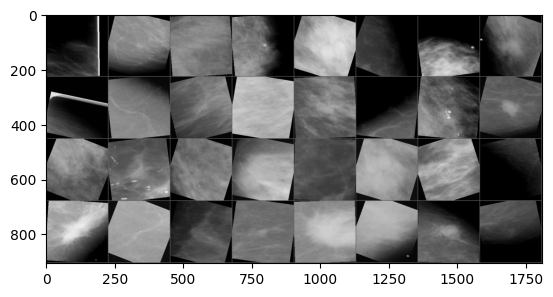

['mass_ben', 'calc_ben', 'calc_ben', 'calc_ben', 'mass_ben', 'background', 'calc_ben', 'mass_mal', 'background', 'background', 'calc_mal', 'calc_mal', 'mass_ben', 'background', 'background', 'mass_mal', 'calc_mal', 'mass_mal', 'background', 'calc_ben', 'background', 'mass_ben', 'calc_ben', 'background', 'mass_mal', 'calc_ben', 'calc_mal', 'mass_ben', 'mass_mal', 'calc_mal', 'mass_mal', 'mass_ben']


In [ ]:
import matplotlib.pyplot as plt
from skimage import io, img_as_float32
import numpy as np
import torch

# To get one image:
# temp_img, temp_lab = train_dataset[0]
# print(temp_img.shape)
# imshow(temp_img, title=num_labels[temp_lab.item()])
# plt.title(num_labels[temp_lab.item()])

# To get a batch of images
temp_img, temp_lab = next(iter(dataloaders["train"]))
# Make a grid from batch
out = torchvision.utils.make_grid(temp_img)
imshow(out)
# imshow(out, title=[num_labels[x.item()] for x in temp_lab])
labels_list = [num_labels[x.item()] for x in temp_lab]
print(labels_list)
plt.show()

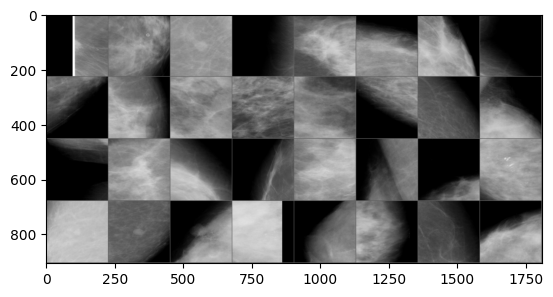

['mass_mal', 'calc_ben', 'mass_mal', 'background', 'mass_mal', 'mass_ben', 'mass_mal', 'background', 'background', 'calc_mal', 'calc_mal', 'background', 'calc_mal', 'background', 'background', 'background', 'background', 'mass_mal', 'background', 'background', 'calc_mal', 'mass_ben', 'background', 'calc_mal', 'mass_ben', 'mass_ben', 'mass_ben', 'calc_mal', 'background', 'background', 'background', 'background']


In [ ]:
# To get a batch of images
temp_img, temp_lab = next(iter(dataloaders["val"]))
# Make a grid from batch
out = torchvision.utils.make_grid(temp_img)
imshow(out)
# imshow(out, title=[num_labels[x.item()] for x in temp_lab])
labels_list = [num_labels[x.item()] for x in temp_lab]
print(labels_list)
plt.show()

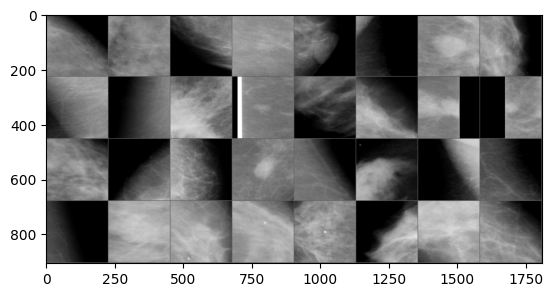

In [ ]:
# To get a batch of images
temp_img, temp_lab = next(iter(dataloaders["test"]))
# Make a grid from batch
out = torchvision.utils.make_grid(temp_img)
imshow(out)
# imshow(out, title=[num_labels[x.item()] for x in temp_lab])

plt.show()

## Setting up training functions

Resources:
* https://pytorch.org/tutorials/beginner/transfer_learning_tutorial.html

In [ ]:
from __future__ import print_function, division

import torch
import torch.nn as nn
import torch.optim as optim
from torch.optim import lr_scheduler
import torch.backends.cudnn as cudnn
import numpy as np
import torchvision
from torchvision import datasets, models, transforms
import matplotlib.pyplot as plt
import time
import os
import copy
import random

cudnn.benchmark = True
plt.ion()   # interactive mode

In [ ]:
def train_model(model, criterion, optimizer, scheduler, num_epochs=25):
    since = time.time()

    best_model_wts = copy.deepcopy(model.state_dict())
    best_acc = 0.0

    # # For book-keeping the losses and accuracies
    # epoch_ls = []
    # train_loss_ls = []
    # val_loss_ls = []
    # train_acc_ls = []
    # val_acc_ls = []

    for epoch in range(num_epochs):
        print(f'Epoch {epoch}/{num_epochs - 1}')
        print('-' * 10)

        # Each epoch has a training and validation phase
        for phase in ['train', 'val']:
            if phase == 'train':
                model.train()  # Set model to training mode
            else:
                model.eval()   # Set model to evaluate mode

            running_loss = 0.0
            running_corrects = 0

            # Iterate over data.
            for inputs, labels in dataloaders[phase]:
                inputs = inputs.to(device)
                labels = labels.to(device)

                # zero the parameter gradients
                optimizer.zero_grad()

                # forward
                # track history if only in train
                with torch.set_grad_enabled(phase == 'train'):
                    outputs = model(inputs)
                    _, preds = torch.max(outputs, 1)
                    loss = criterion(outputs, labels)

                    # backward + optimize only if in training phase
                    if phase == 'train':
                        loss.backward()
                        optimizer.step()

                # statistics
                running_loss += loss.item() * inputs.size(0)
                running_corrects += torch.sum(preds == labels.data)

            if phase == 'train':
                scheduler.step()

            epoch_loss = running_loss / dataset_sizes[phase]
            epoch_acc = running_corrects.double() / dataset_sizes[phase]

            print(f'{phase} Loss: {epoch_loss:.4f} Acc: {epoch_acc:.4f}')

            # deep copy the model
            if phase == 'val' and epoch_acc > best_acc:
                best_acc = epoch_acc
                best_model_wts = copy.deepcopy(model.state_dict())

        print()

    time_elapsed = time.time() - since
    print(f'Training complete in {time_elapsed // 60:.0f}m {time_elapsed % 60:.0f}s')
    print(f'Best val Acc: {best_acc:4f}')

    # load best model weights
    model.load_state_dict(best_model_wts)
    return model

In [ ]:
def visualize_model(model, num_images=6):
    was_training = model.training
    model.eval()
    images_so_far = 0
    fig = plt.figure()

    with torch.no_grad():
        for i, (inputs, labels) in enumerate(dataloaders['val']):
            inputs = inputs.to(device)
            labels = labels.to(device)

            outputs = model(inputs)
            _, preds = torch.max(outputs, 1)

            for j in range(inputs.size()[0]):
                images_so_far += 1
                ax = plt.subplot(num_images//2, 2, images_so_far)
                ax.axis('off')
                ax.set_title(f'predicted: {num_labels[preds[j]]}')
                imshow(inputs.cpu().data[j])

                if images_so_far == num_images:
                    model.train(mode=was_training)
                    return
        model.train(mode=was_training)

# Best ResNet18 Results

In [ ]:
model_ft = models.resnet18(weights="DEFAULT")
num_ftrs = model_ft.fc.in_features

model_ft.fc = nn.Linear(num_ftrs, 5)

model_ft = model_ft.to(device)

criterion = nn.CrossEntropyLoss()

# Observe that all parameters are being optimized
optimizer_ft = optim.Adam(model_ft.parameters(), lr=0.0001)

# Decay LR by a factor of 0.1 every 10 epochs
exp_lr_scheduler = lr_scheduler.StepLR(optimizer_ft, step_size=10, gamma=0.1)

Downloading: "https://download.pytorch.org/models/resnet18-f37072fd.pth" to /root/.cache/torch/hub/checkpoints/resnet18-f37072fd.pth


  0%|          | 0.00/44.7M [00:00<?, ?B/s]

In [ ]:
model_ft = train_model(model_ft, criterion, optimizer_ft, exp_lr_scheduler,
                       num_epochs=25)

Epoch 0/24
----------
train Loss: 1.1491 Acc: 0.5262
val Loss: 0.7168 Acc: 0.7390

Epoch 1/24
----------
train Loss: 0.8037 Acc: 0.6791
val Loss: 0.5819 Acc: 0.7739

Epoch 2/24
----------
train Loss: 0.6994 Acc: 0.7211
val Loss: 0.5509 Acc: 0.7812

Epoch 3/24
----------
train Loss: 0.6438 Acc: 0.7411
val Loss: 0.7047 Acc: 0.7408

Epoch 4/24
----------
train Loss: 0.6051 Acc: 0.7683
val Loss: 0.5847 Acc: 0.7445

Epoch 5/24
----------
train Loss: 0.5672 Acc: 0.7726
val Loss: 0.5528 Acc: 0.7812

Epoch 6/24
----------
train Loss: 0.5277 Acc: 0.7957
val Loss: 0.5335 Acc: 0.7941

Epoch 7/24
----------
train Loss: 0.4924 Acc: 0.8047
val Loss: 0.5687 Acc: 0.7923

Epoch 8/24
----------
train Loss: 0.4810 Acc: 0.8139
val Loss: 0.5887 Acc: 0.7849

Epoch 9/24
----------
train Loss: 0.4524 Acc: 0.8182
val Loss: 0.7049 Acc: 0.7555

Epoch 10/24
----------
train Loss: 0.3813 Acc: 0.8603
val Loss: 0.5953 Acc: 0.7904

Epoch 11/24
----------
train Loss: 0.3393 Acc: 0.8748
val Loss: 0.5856 Acc: 0.8070

Ep

In [ ]:
# Save the best model
torch.save(model_ft.state_dict(), save_models_dir+'best_resnet18_dsnormalized.pt')

# Best ResNet50 Results
Read from bottom up, since most updated model training is higher up.

## With new TRAIN DATASET mean std normalization

In [ ]:
model_ft = models.resnet50(weights="DEFAULT")
num_ftrs = model_ft.fc.in_features

model_ft.fc = nn.Linear(num_ftrs, 5)

model_ft = model_ft.to(device)

criterion = nn.CrossEntropyLoss()

# Observe that all parameters are being optimized
optimizer_ft = optim.Adam(model_ft.parameters(), lr=0.0001)

# Decay LR by a factor of 0.1 every 10 epochs
exp_lr_scheduler = lr_scheduler.StepLR(optimizer_ft, step_size=10, gamma=0.1)

Downloading: "https://download.pytorch.org/models/resnet50-11ad3fa6.pth" to /root/.cache/torch/hub/checkpoints/resnet50-11ad3fa6.pth


  0%|          | 0.00/97.8M [00:00<?, ?B/s]

In [ ]:
model_ft = train_model(model_ft, criterion, optimizer_ft, exp_lr_scheduler,
                       num_epochs=25)

Epoch 0/24
----------
train Loss: 1.1656 Acc: 0.5258
val Loss: 0.7556 Acc: 0.7114

Epoch 1/24
----------
train Loss: 0.7769 Acc: 0.6973
val Loss: 0.6883 Acc: 0.7316

Epoch 2/24
----------
train Loss: 0.6561 Acc: 0.7429
val Loss: 0.5570 Acc: 0.7941

Epoch 3/24
----------
train Loss: 0.6004 Acc: 0.7708
val Loss: 0.6406 Acc: 0.7721

Epoch 4/24
----------
train Loss: 0.5430 Acc: 0.7894
val Loss: 0.5426 Acc: 0.7960

Epoch 5/24
----------
train Loss: 0.4911 Acc: 0.8176
val Loss: 0.5044 Acc: 0.8235

Epoch 6/24
----------
train Loss: 0.4539 Acc: 0.8241
val Loss: 0.5849 Acc: 0.7923

Epoch 7/24
----------
train Loss: 0.4015 Acc: 0.8458
val Loss: 0.5712 Acc: 0.8180

Epoch 8/24
----------
train Loss: 0.3660 Acc: 0.8640
val Loss: 0.5592 Acc: 0.7996

Epoch 9/24
----------
train Loss: 0.3550 Acc: 0.8691
val Loss: 0.6329 Acc: 0.8125

Epoch 10/24
----------
train Loss: 0.2929 Acc: 0.8918
val Loss: 0.5708 Acc: 0.8199

Epoch 11/24
----------
train Loss: 0.2454 Acc: 0.9106
val Loss: 0.5734 Acc: 0.8162

Ep

In [ ]:
# Save the best model
torch.save(model_ft.state_dict(), save_models_dir+'best_resnet50_dsnormalized.pt')

# Best VGG16_BN Results

## VGG16_BN, 25 epochs

In [ ]:
model_ft = models.vgg16_bn(weights="DEFAULT")
# num_ftrs = model_ft.fc.in_features

num_ftrs = model_ft.classifier[6].in_features # the 6 gets me to the linear layer of VGG
model_ft.classifier[6] = nn.Linear(num_ftrs, 5)


model_ft = model_ft.to(device)

criterion = nn.CrossEntropyLoss()

# Observe that all parameters are being optimized
optimizer_ft = optim.Adam(model_ft.parameters(), lr=0.0001)

# Decay LR by a factor of 0.1 every 7 epochs
exp_lr_scheduler = lr_scheduler.StepLR(optimizer_ft, step_size=10, gamma=0.1)

Downloading: "https://download.pytorch.org/models/vgg16_bn-6c64b313.pth" to /root/.cache/torch/hub/checkpoints/vgg16_bn-6c64b313.pth


  0%|          | 0.00/528M [00:00<?, ?B/s]

In [ ]:
model_ft = train_model(model_ft, criterion, optimizer_ft, exp_lr_scheduler,
                       num_epochs=25)

Epoch 0/24
----------
train Loss: 1.0907 Acc: 0.5397
val Loss: 0.6777 Acc: 0.7500

Epoch 1/24
----------
train Loss: 0.7696 Acc: 0.6963
val Loss: 0.6017 Acc: 0.7665

Epoch 2/24
----------
train Loss: 0.6742 Acc: 0.7354
val Loss: 0.5403 Acc: 0.7849

Epoch 3/24
----------
train Loss: 0.5957 Acc: 0.7624
val Loss: 0.5533 Acc: 0.8033

Epoch 4/24
----------
train Loss: 0.5869 Acc: 0.7765
val Loss: 0.4964 Acc: 0.8162

Epoch 5/24
----------
train Loss: 0.5186 Acc: 0.8002
val Loss: 0.4867 Acc: 0.8254

Epoch 6/24
----------
train Loss: 0.5298 Acc: 0.8035
val Loss: 0.5548 Acc: 0.8162

Epoch 7/24
----------
train Loss: 0.4878 Acc: 0.8096
val Loss: 0.4637 Acc: 0.8290

Epoch 8/24
----------
train Loss: 0.4489 Acc: 0.8319
val Loss: 0.5369 Acc: 0.8107

Epoch 9/24
----------
train Loss: 0.3995 Acc: 0.8476
val Loss: 0.5098 Acc: 0.7941

Epoch 10/24
----------
train Loss: 0.3377 Acc: 0.8718
val Loss: 0.4599 Acc: 0.8217

Epoch 11/24
----------
train Loss: 0.3103 Acc: 0.8855
val Loss: 0.4553 Acc: 0.8254

Ep

In [ ]:
# Save the best model
torch.save(model_ft.state_dict(), save_models_dir+'best_vgg16_new.pt')

In [ ]:
# Save checkpoint
torch.save({'epoch': 25,
            'model_state_dict': model_ft.state_dict(),
            'optimizer_state_dict': optimizer_ft.state_dict(),
            }, save_models_dir+'best_vgg16_new_CHECKPOINT25.pt')

# Best VGG19 Results

## VGG19_BN for 25 epochs

In [ ]:
model_ft = models.vgg19_bn(weights="DEFAULT")
num_ftrs = model_ft.classifier[6].in_features # the 6 gets me to the linear layer of VGG
model_ft.classifier[6] = nn.Linear(num_ftrs, 5)

model_ft = model_ft.to(device)

criterion = nn.CrossEntropyLoss()

# Observe that all parameters are being optimized
optimizer_ft = optim.Adam(model_ft.parameters(), lr=0.0001)

# Decay LR by a factor of 0.1 every 7 epochs
exp_lr_scheduler = lr_scheduler.StepLR(optimizer_ft, step_size=10, gamma=0.1)

Downloading: "https://download.pytorch.org/models/vgg19_bn-c79401a0.pth" to /root/.cache/torch/hub/checkpoints/vgg19_bn-c79401a0.pth


  0%|          | 0.00/548M [00:00<?, ?B/s]

In [ ]:
model_ft

VGG(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
    (3): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (4): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): ReLU(inplace=True)
    (6): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (7): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (8): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (9): ReLU(inplace=True)
    (10): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (12): ReLU(inplace=True)
    (13): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (14): Conv2d(128, 256

In [ ]:
model_ft = train_model(model_ft, criterion, optimizer_ft, exp_lr_scheduler,
                       num_epochs=25)

Epoch 0/24
----------
train Loss: 1.0592 Acc: 0.5697
val Loss: 0.7342 Acc: 0.7316

Epoch 1/24
----------
train Loss: 0.7377 Acc: 0.7176
val Loss: 0.5556 Acc: 0.7886

Epoch 2/24
----------
train Loss: 0.6527 Acc: 0.7462
val Loss: 0.5968 Acc: 0.7721

Epoch 3/24
----------
train Loss: 0.6235 Acc: 0.7607
val Loss: 0.6187 Acc: 0.7665

Epoch 4/24
----------
train Loss: 0.5593 Acc: 0.7838
val Loss: 0.6084 Acc: 0.7757

Epoch 5/24
----------
train Loss: 0.5325 Acc: 0.7953
val Loss: 0.5601 Acc: 0.8015

Epoch 6/24
----------
train Loss: 0.4992 Acc: 0.8110
val Loss: 0.6006 Acc: 0.7831

Epoch 7/24
----------
train Loss: 0.4702 Acc: 0.8239
val Loss: 0.6602 Acc: 0.7886

Epoch 8/24
----------
train Loss: 0.4394 Acc: 0.8354
val Loss: 0.6502 Acc: 0.7996

Epoch 9/24
----------
train Loss: 0.3959 Acc: 0.8507
val Loss: 0.5708 Acc: 0.8033

Epoch 10/24
----------
train Loss: 0.3471 Acc: 0.8720
val Loss: 0.5564 Acc: 0.8235

Epoch 11/24
----------
train Loss: 0.2843 Acc: 0.8900
val Loss: 0.5842 Acc: 0.8235

Ep

In [ ]:
torch.save(model_ft.state_dict(), save_models_dir+'best_vgg19_new.pt')

In [ ]:
# Save checkpoint
torch.save({'epoch': 25,
            'model_state_dict': model_ft.state_dict(),
            'optimizer_state_dict': optimizer_ft.state_dict(),
            }, save_models_dir+'best_vgg19_new_CHECKPOINT25.pt')

# Best EfficientNet Results (EfficientNet B3)

In [ ]:
efficentnet_model = models.efficientnet_b3(weights="DEFAULT")
num_ftrs = efficentnet_model.classifier[1].in_features
# Alternatively, it can be generalized to nn.Linear(num_ftrs, len(class_names)).
efficentnet_model.classifier[1] = nn.Linear(num_ftrs, 5)

efficentnet_model = efficentnet_model.to(device)

criterion = nn.CrossEntropyLoss()

# Observe that all parameters are being optimized
optimizer_ft = optim.Adam(efficentnet_model.parameters(), lr=0.0001)

# Decay LR by a factor of 0.1 every (step_size) epochs
exp_lr_scheduler = lr_scheduler.StepLR(optimizer_ft, step_size=10, gamma=0.1)# Save the best model

Downloading: "https://download.pytorch.org/models/efficientnet_b3_rwightman-cf984f9c.pth" to /root/.cache/torch/hub/checkpoints/efficientnet_b3_rwightman-cf984f9c.pth


  0%|          | 0.00/47.2M [00:00<?, ?B/s]

In [ ]:
efficentnet_model = train_model(efficentnet_model, criterion, optimizer_ft, exp_lr_scheduler,
                       num_epochs=25)

Epoch 0/24
----------
train Loss: 1.3304 Acc: 0.4546
val Loss: 0.8921 Acc: 0.6728

Epoch 1/24
----------
train Loss: 0.8921 Acc: 0.6479
val Loss: 0.7070 Acc: 0.7261

Epoch 2/24
----------
train Loss: 0.7308 Acc: 0.7072
val Loss: 0.6533 Acc: 0.7390

Epoch 3/24
----------
train Loss: 0.6304 Acc: 0.7605
val Loss: 0.6230 Acc: 0.7574

Epoch 4/24
----------
train Loss: 0.5603 Acc: 0.7806
val Loss: 0.6147 Acc: 0.7610

Epoch 5/24
----------
train Loss: 0.5145 Acc: 0.7990
val Loss: 0.5860 Acc: 0.7776

Epoch 6/24
----------
train Loss: 0.4504 Acc: 0.8294
val Loss: 0.5734 Acc: 0.7794

Epoch 7/24
----------
train Loss: 0.4181 Acc: 0.8423
val Loss: 0.5378 Acc: 0.8033

Epoch 8/24
----------
train Loss: 0.3703 Acc: 0.8622
val Loss: 0.5460 Acc: 0.7996

Epoch 9/24
----------
train Loss: 0.3480 Acc: 0.8732
val Loss: 0.5934 Acc: 0.7868

Epoch 10/24
----------
train Loss: 0.3077 Acc: 0.8863
val Loss: 0.5832 Acc: 0.7960

Epoch 11/24
----------
train Loss: 0.2932 Acc: 0.8951
val Loss: 0.5787 Acc: 0.8051

Ep

In [ ]:
# Save the best model
torch.save(efficentnet_model.state_dict(), save_models_dir+'best_efficientnetb3_model.pt')

In [ ]:
# Save checkpoint
torch.save({'epoch': 25,
            'model_state_dict': efficentnet_model.state_dict(),
            'optimizer_state_dict': optimizer_ft.state_dict(),
            }, save_models_dir+'best_efficientnetb3_CHECKPOINT25.pt')

# Training Ensemble (Stacking/blending)

## Stacked ensemble

In [ ]:
class load_VGG19_BN(nn.Module):
    def __init__(self):
        super(load_VGG19_BN, self).__init__()
        self.model = torchvision.models.vgg19_bn()
        #print(self.model)
        num_ftrs = self.model.classifier[6].in_features
        self.model.classifier[6] = nn.Linear(num_ftrs, 5)
        self.model.load_state_dict(torch.load(save_models_dir+'best_vgg19_new.pt'))
        # self.model.eval()
    def forward(self, x):        
        return self.model(x)

class load_VGG16_BN(nn.Module):
    def __init__(self):
        super(load_VGG16_BN, self).__init__()
        self.model = torchvision.models.vgg16_bn()
        #print(self.model)
        num_ftrs = self.model.classifier[6].in_features
        self.model.classifier[6] = nn.Linear(num_ftrs, 5)
        self.model.load_state_dict(torch.load(save_models_dir+'best_vgg16_new.pt'))
        # self.model.eval()         
    def forward(self, x):        
        return self.model(x)

class load_ResNet50(nn.Module):
    def __init__(self):
        super(load_ResNet50, self).__init__()
        self.model = torchvision.models.resnet50()
        #print(self.model)
        num_ftrs = self.model.fc.in_features
        self.model.fc = nn.Linear(num_ftrs, 5)
        self.model.load_state_dict(torch.load(save_models_dir+'best_resnet50_dsnormalized.pt'))
        # self.model.eval()        
    def forward(self, x):        
        return self.model(x)

In [ ]:
class StackedEnsemble(nn.Module):
    """
    Stacked ensembling / blending ensemble technique
    """

    def __init__(self,  modelA, modelB, modelC):
        super(StackedEnsemble, self).__init__()
        
        self.modelA = modelA
        self.modelB = modelB
        self.modelC = modelC

        self.classifier = nn.Linear(5*3, 5)
                
    def forward(self, x):
        # self.modelA.eval()  
        x1 = self.modelA(x)

        # self.modelB.eval()
        x2 = self.modelB(x)

        # self.modelC.eval()
        x3 = self.modelC(x)

        x = torch.cat((x1, x2, x3), dim=1)
        out = self.classifier(x)
        return out

In [ ]:
# ResNet50
resnet50_model = load_ResNet50()
# num_ftrs = resnet50_model.fc.in_features
# resnet50_model.fc = nn.Linear(num_ftrs, 5)
# resnet50_model.load_state_dict(torch.load(save_models_dir+'best_resnet50_dsnormalized.pt'))
# resnet50_model = resnet50_model.to(device)

# VGG16_BN
vgg16_bn_model = load_VGG16_BN()
# num_ftrs = vgg16_bn_model.classifier[6].in_features
# vgg16_bn_model.fc = nn.Linear(num_ftrs, 5)
# vgg16_bn_model.load_state_dict(torch.load(save_models_dir+'best_vgg16.pt'))
# vgg16_bn_model = vgg16_bn_model.to(device)

# VGG19_BN
vgg19_bn_model = load_VGG19_BN()
# num_ftrs = vgg19_bn_model.classifier[6].in_features
# vgg19_bn_model.fc = nn.Linear(num_ftrs, 5)
# vgg19_bn_model.load_state_dict(torch.load(save_models_dir+'best_vgg19_bn_model.pt'))
# vgg19_bn_model = vgg19_bn_model.to(device)

In [ ]:
vgg19_bn_model

load_VGG19_BN(
  (model): VGG(
    (features): Sequential(
      (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): ReLU(inplace=True)
      (3): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (4): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (5): ReLU(inplace=True)
      (6): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
      (7): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (8): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (9): ReLU(inplace=True)
      (10): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (11): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (12): ReLU(inplace=True)
      (13): MaxPool2d(kernel_size=2, stride=2, padding=0

In [ ]:
vgg16_bn_model

load_VGG16_BN(
  (model): VGG(
    (features): Sequential(
      (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): ReLU(inplace=True)
      (3): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (4): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (5): ReLU(inplace=True)
      (6): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
      (7): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (8): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (9): ReLU(inplace=True)
      (10): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (11): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (12): ReLU(inplace=True)
      (13): MaxPool2d(kernel_size=2, stride=2, padding=0

In [ ]:
resnet50_model

load_ResNet50(
  (model): ResNet(
    (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (relu): ReLU(inplace=True)
    (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (layer1): Sequential(
      (0): Bottleneck(
        (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu): ReLU(inplace=True)
        (downsample): Sequential(
      

In [ ]:
# models = [resnet50_model, vgg16_bn_model, vgg19_bn_model]
stacked_ensemble_model = StackedEnsemble(resnet50_model, vgg16_bn_model, vgg19_bn_model)

for param in stacked_ensemble_model.parameters():
  param.requires_grad = False

# Training for only this layer - what weights and biases can best combine each 
# sub-model prediction?
for param in stacked_ensemble_model.classifier.parameters():
  param.requires_grad = True

stacked_ensemble_model = stacked_ensemble_model.to(device)

criterion = nn.CrossEntropyLoss()

# Observe that all parameters are being optimized
optimizer = optim.Adam(stacked_ensemble_model.parameters(), lr=0.0001)

# Decay LR by a factor of 0.1 every 7 epochs
exp_lr_scheduler = lr_scheduler.StepLR(optimizer, step_size=10, gamma=0.1)

In [ ]:
stacked_ensemble_model = train_model(stacked_ensemble_model , criterion, optimizer, exp_lr_scheduler,
                       num_epochs=25)

Epoch 0/24
----------
train Loss: 2.2658 Acc: 0.2192
val Loss: 1.7588 Acc: 0.2537

Epoch 1/24
----------
train Loss: 1.7094 Acc: 0.3368
val Loss: 1.3114 Acc: 0.4026

Epoch 2/24
----------
train Loss: 1.3202 Acc: 0.5008
val Loss: 0.9914 Acc: 0.6654

Epoch 3/24
----------
train Loss: 1.0461 Acc: 0.6317
val Loss: 0.7784 Acc: 0.7647

Epoch 4/24
----------
train Loss: 0.8651 Acc: 0.6922
val Loss: 0.6272 Acc: 0.8033

Epoch 5/24
----------
train Loss: 0.7218 Acc: 0.7339
val Loss: 0.5301 Acc: 0.8346

Epoch 6/24
----------
train Loss: 0.6302 Acc: 0.7648
val Loss: 0.4619 Acc: 0.8529

Epoch 7/24
----------
train Loss: 0.5449 Acc: 0.8102
val Loss: 0.4088 Acc: 0.8658

Epoch 8/24
----------
train Loss: 0.4879 Acc: 0.8344
val Loss: 0.3698 Acc: 0.8805

Epoch 9/24
----------
train Loss: 0.4430 Acc: 0.8526
val Loss: 0.3354 Acc: 0.8952

Epoch 10/24
----------
train Loss: 0.4186 Acc: 0.8679
val Loss: 0.3382 Acc: 0.8915

Epoch 11/24
----------
train Loss: 0.4386 Acc: 0.8548
val Loss: 0.3325 Acc: 0.8897

Ep

In [ ]:
# Save the best model
torch.save(stacked_ensemble_model.state_dict(), save_models_dir+'stacked_ensemble_attempt2_vgg16bn_vgg19bn_resnet50.pt')

# Entry Submissions

In [ ]:
def model_test(model):
  results = {}
  
  model.to(device)
  with torch.no_grad():
    for i, (inputs, labels) in enumerate(dataloaders['test']):
      inputs = inputs.to(device)
      # labels = labels.to(device)
      # print(len(labels))

      outputs = model(inputs)
      _, preds = torch.max(outputs, 1)

      # print(preds)
      preds_list = [num_labels[x.item()] for x in preds]
      # print(len(preds_list))

      for i in range(len(labels)):
        results[labels[i]] = preds_list[i]

  return results

In [ ]:
def ensemble_averaging(modelA, modelB, modelC):
  """
  This function implements a simple ensemble technique of averaging model 
  predictions to directly make a prediction
  """
  results = {}
  
  modelA.to(device)
  modelB.to(device)
  modelC.to(device)

  with torch.no_grad():
    for i, (inputs, labels) in enumerate(dataloaders['test']):
      inputs = inputs.to(device)
      # labels = labels.to(device)
      # print(len(labels))

      # outputs = model(inputs)
      out_modelA = modelA(inputs)
      print(out_modelA.shape)
      out_modelB = modelB(inputs)
      print(out_modelB.shape)
      out_modelC = modelC(inputs)
      print(out_modelC.shape)

      outputs = (out_modelA + out_modelB + out_modelC) / 3
      print("\nAveraged outputs for this batch:\n{}\n".format(outputs))
      _, preds = torch.max(outputs, 1)

      # print(preds)
      preds_list = [num_labels[x.item()] for x in preds]
      # print(len(preds_list))

      for i in range(len(labels)):
        results[labels[i]] = preds_list[i]

  return results

For 4 models

In [ ]:
def ensemble_averaging(modelA, modelB, modelC, modelD):
  """
  This function implements a simple ensemble technique of averaging model 
  predictions to directly make a prediction
  """
  results = {}
  
  modelA.to(device)
  modelB.to(device)
  modelC.to(device)
  modelD.to(device)

  with torch.no_grad():
    for i, (inputs, labels) in enumerate(dataloaders['test']):
      inputs = inputs.to(device)
      # labels = labels.to(device)
      # print(len(labels))

      # outputs = model(inputs)
      out_modelA = modelA(inputs)
      print(out_modelA.shape)
      out_modelB = modelB(inputs)
      print(out_modelB.shape)
      out_modelC = modelC(inputs)
      print(out_modelC.shape)
      out_modelD = modelD(inputs)
      print(out_modelD.shape)

      outputs = (out_modelA + out_modelB + out_modelC + out_modelD) / 4
      print("\nAveraged outputs for this batch:\n{}\n".format(outputs))
      _, preds = torch.max(outputs, 1)

      # print(preds)
      preds_list = [num_labels[x.item()] for x in preds]
      # print(len(preds_list))

      for i in range(len(labels)):
        results[labels[i]] = preds_list[i]

  return results

For 5 models

In [ ]:
def ensemble_averaging(modelA, modelB, modelC, modelD, modelE):
  """
  This function implements a simple ensemble technique of averaging model 
  predictions to directly make a prediction
  """
  results = {}
  
  modelA.to(device)
  modelB.to(device)
  modelC.to(device)
  modelD.to(device)
  modelE.to(device)

  with torch.no_grad():
    for i, (inputs, labels) in enumerate(dataloaders['test']):
      inputs = inputs.to(device)
      # labels = labels.to(device)
      # print(len(labels))

      # outputs = model(inputs)
      out_modelA = modelA(inputs)
      print(out_modelA.shape)
      out_modelB = modelB(inputs)
      print(out_modelB.shape)
      out_modelC = modelC(inputs)
      print(out_modelC.shape)
      out_modelD = modelD(inputs)
      print(out_modelD.shape)
      out_modelE = modelE(inputs)
      print(out_modelE.shape)

      outputs = (out_modelA + out_modelB + out_modelC + out_modelD + out_modelE) / 5
      # print("\nAveraged outputs for this batch:\n{}\n".format(outputs))
      _, preds = torch.max(outputs, 1)

      # print(preds)
      preds_list = [num_labels[x.item()] for x in preds]
      # print(len(preds_list))

      for i in range(len(labels)):
        results[labels[i]] = preds_list[i]

  return results

## Ensemble though simple, unweighted averaging of 5 individual model predictions
Val acc: 

See different ensemble techniques here: https://web.archive.org/web/20210724194837/https://mlwave.com/kaggle-ensembling-guide/

In [ ]:
class load_VGG19_BN(nn.Module):
    def __init__(self):
        super(load_VGG19_BN, self).__init__()
        self.model = torchvision.models.vgg19_bn()
        #print(self.model)
        num_ftrs = self.model.classifier[6].in_features
        self.model.classifier[6] = nn.Linear(num_ftrs, 5)
        self.model.load_state_dict(torch.load(save_models_dir+'best_vgg19_new.pt'))
        self.model.eval()
    def forward(self, x):        
        return self.model(x)

class load_VGG16_BN(nn.Module):
    def __init__(self):
        super(load_VGG16_BN, self).__init__()
        self.model = torchvision.models.vgg16_bn()
        #print(self.model)
        num_ftrs = self.model.classifier[6].in_features
        self.model.classifier[6] = nn.Linear(num_ftrs, 5)
        self.model.load_state_dict(torch.load(save_models_dir+'best_vgg16_new.pt'))
        self.model.eval()         
    def forward(self, x):        
        return self.model(x)

class load_ResNet50(nn.Module):
    def __init__(self):
        super(load_ResNet50, self).__init__()
        self.model = torchvision.models.resnet50()
        #print(self.model)
        num_ftrs = self.model.fc.in_features
        self.model.fc = nn.Linear(num_ftrs, 5)
        self.model.load_state_dict(torch.load(save_models_dir+'best_resnet50_dsnormalized.pt'))
        self.model.eval()        
    def forward(self, x):        
        return self.model(x)

class load_ResNet18(nn.Module):
    def __init__(self):
        super(load_ResNet18, self).__init__()
        self.model = torchvision.models.resnet18()
        #print(self.model)
        num_ftrs = self.model.fc.in_features
        self.model.fc = nn.Linear(num_ftrs, 5)
        self.model.load_state_dict(torch.load(save_models_dir+'best_resnet18_dsnormalized.pt'))
        self.model.eval()        
    def forward(self, x):        
        return self.model(x)

class load_EfficientNet_B3(nn.Module):
    def __init__(self):
        super(load_EfficientNet_B3, self).__init__()
        self.model = torchvision.models.efficientnet_b3()
        #print(self.model)
        num_ftrs = self.model.classifier[1].in_features
        self.model.classifier[1] = nn.Linear(num_ftrs, 5)
        self.model.load_state_dict(torch.load(save_models_dir+'best_efficientnetb3_model.pt'))
        self.model.eval()        
    def forward(self, x):        
        return self.model(x)

In [ ]:
# ResNet50
resnet50_model = load_ResNet50()
# print(resnet50_model)
# resnet50_model = resnet50_model.to(device)

# ResNet18
resnet18_model = load_ResNet18()
# print(resnet50_model)
# resnet50_model = resnet50_model.to(device)

# VGG16_BN
vgg16_bn_model = load_VGG16_BN()
# print(vgg16_bn_model)
# vgg16_bn_model = vgg16_bn_model.to(device)

# VGG19_BN
vgg19_bn_model = load_VGG19_BN()
# print(vgg19_bn_model)
# vgg19_bn_model = vgg19_bn_model.to(device)

In [ ]:
results = ensemble_averaging(resnet50_model, resnet18_model, vgg16_bn_model, vgg19_bn_model)

torch.Size([32, 5])
torch.Size([32, 5])
torch.Size([32, 5])
torch.Size([32, 5])

Averaged outputs for this batch:
tensor([[ 7.2029,  1.0328, -2.9400, -2.5249, -4.7830],
        [ 3.1115,  3.2715, -0.7848, -2.5442, -4.6412],
        [ 8.7175,  0.9293, -4.2067, -2.6845, -4.6302],
        [-3.4128, -2.4673, -3.0509,  4.6762,  2.6485],
        [ 2.4920, -0.5753, -3.9804,  2.9646, -2.1282],
        [10.6072, -1.2452, -4.6920, -3.4932, -3.9876],
        [-3.7717, -2.8422, -1.2879,  3.8541,  2.3291],
        [ 1.8783,  3.1733,  0.1628, -2.4431, -4.4154],
        [ 6.8863,  0.6412, -2.6805, -3.6495, -3.3074],
        [ 9.9794,  0.4799, -5.0243, -3.2208, -4.5857],
        [-2.0921,  2.7291,  6.1903, -6.1026, -3.5092],
        [-4.3128, -0.4583, -2.6749,  5.7073,  0.1113],
        [ 8.1269,  1.2418, -3.5292, -2.1312, -5.0623],
        [ 6.5311,  0.6051, -3.3366, -1.0805, -4.0902],
        [-3.6478, -1.2778, -0.8952,  4.1677, -0.3283],
        [-5.1326, -3.7146, -3.2509,  3.7684,  6.2561],
      

In [ ]:
submission_df = pd.DataFrame.from_dict(results, orient="index",
                                       columns=["label"])
submission_df = submission_df.reset_index()
submission_df = submission_df.rename({"index":"id"}, axis="columns")
submission_df

,id,label
0,P100000,background
1,P100001,calc_ben
2,P100002,background
3,P100003,mass_ben
4,P100004,mass_ben
...,...,...
1230,P101230,mass_ben
1231,P101231,calc_ben
1232,P101232,background
1233,P101233,background


In [ ]:
# Save to two places - Google Drive and content
submission_df.to_csv(save_models_dir+'submissions/ensemble_avg_vgg16_vgg19_resnet50_resnet18.csv',
                    index=False)

submission_df.to_csv('/content/submission.csv',
                    index=False)

## Stacked ensemble attempt 2 

In [ ]:
stacked_ensemble_model.eval()
results = model_test(stacked_ensemble_model)
submission_df = pd.DataFrame.from_dict(results, orient="index",
                                       columns=["label"])
submission_df = submission_df.reset_index()
submission_df = submission_df.rename({"index":"id"}, axis="columns")
submission_df

,id,label
0,P100000,background
1,P100001,calc_ben
2,P100002,background
3,P100003,mass_ben
4,P100004,background
...,...,...
1230,P101230,mass_ben
1231,P101231,calc_ben
1232,P101232,mass_ben
1233,P101233,background


In [ ]:
# Save to two places - Google Drive and content
submission_df.to_csv(save_models_dir+'submissions/stacked_ensemble_attempt2_avg_vgg16_vgg19_resnet50.csv',
                    index=False)

submission_df.to_csv('/content/submission.csv',
                    index=False)

## Ensemble though simple, unweighted averaging of 4 individual model predictions
Val acc: 0.80388

See different ensemble techniques here: https://web.archive.org/web/20210724194837/https://mlwave.com/kaggle-ensembling-guide/

In [ ]:
class load_VGG19_BN(nn.Module):
    def __init__(self):
        super(load_VGG19_BN, self).__init__()
        self.model = torchvision.models.vgg19_bn()
        #print(self.model)
        num_ftrs = self.model.classifier[6].in_features
        self.model.classifier[6] = nn.Linear(num_ftrs, 5)
        self.model.load_state_dict(torch.load(save_models_dir+'best_vgg19_new.pt'))
        self.model.eval()
    def forward(self, x):        
        return self.model(x)

class load_VGG16_BN(nn.Module):
    def __init__(self):
        super(load_VGG16_BN, self).__init__()
        self.model = torchvision.models.vgg16_bn()
        #print(self.model)
        num_ftrs = self.model.classifier[6].in_features
        self.model.classifier[6] = nn.Linear(num_ftrs, 5)
        self.model.load_state_dict(torch.load(save_models_dir+'best_vgg16_new.pt'))
        self.model.eval()         
    def forward(self, x):        
        return self.model(x)

class load_ResNet50(nn.Module):
    def __init__(self):
        super(load_ResNet50, self).__init__()
        self.model = torchvision.models.resnet50()
        #print(self.model)
        num_ftrs = self.model.fc.in_features
        self.model.fc = nn.Linear(num_ftrs, 5)
        self.model.load_state_dict(torch.load(save_models_dir+'best_resnet50_dsnormalized.pt'))
        self.model.eval()        
    def forward(self, x):        
        return self.model(x)

class load_ResNet18(nn.Module):
    def __init__(self):
        super(load_ResNet18, self).__init__()
        self.model = torchvision.models.resnet18()
        #print(self.model)
        num_ftrs = self.model.fc.in_features
        self.model.fc = nn.Linear(num_ftrs, 5)
        self.model.load_state_dict(torch.load(save_models_dir+'best_resnet18_dsnormalized.pt'))
        self.model.eval()        
    def forward(self, x):        
        return self.model(x)

In [ ]:
# ResNet50
resnet50_model = load_ResNet50()
# print(resnet50_model)
# resnet50_model = resnet50_model.to(device)

# ResNet18
resnet18_model = load_ResNet18()
# print(resnet50_model)
# resnet50_model = resnet50_model.to(device)

# VGG16_BN
vgg16_bn_model = load_VGG16_BN()
# print(vgg16_bn_model)
# vgg16_bn_model = vgg16_bn_model.to(device)

# VGG19_BN
vgg19_bn_model = load_VGG19_BN()
# print(vgg19_bn_model)
# vgg19_bn_model = vgg19_bn_model.to(device)

In [ ]:
results = ensemble_averaging(resnet50_model, resnet18_model, vgg16_bn_model, vgg19_bn_model)

torch.Size([32, 5])
torch.Size([32, 5])
torch.Size([32, 5])
torch.Size([32, 5])

Averaged outputs for this batch:
tensor([[ 7.2029,  1.0328, -2.9400, -2.5249, -4.7830],
        [ 3.1115,  3.2715, -0.7848, -2.5442, -4.6412],
        [ 8.7175,  0.9293, -4.2067, -2.6845, -4.6302],
        [-3.4128, -2.4673, -3.0509,  4.6762,  2.6485],
        [ 2.4920, -0.5753, -3.9804,  2.9646, -2.1282],
        [10.6072, -1.2452, -4.6920, -3.4932, -3.9876],
        [-3.7717, -2.8422, -1.2879,  3.8541,  2.3291],
        [ 1.8783,  3.1733,  0.1628, -2.4431, -4.4154],
        [ 6.8863,  0.6412, -2.6805, -3.6495, -3.3074],
        [ 9.9794,  0.4799, -5.0243, -3.2208, -4.5857],
        [-2.0921,  2.7291,  6.1903, -6.1026, -3.5092],
        [-4.3128, -0.4583, -2.6749,  5.7073,  0.1113],
        [ 8.1269,  1.2418, -3.5292, -2.1312, -5.0623],
        [ 6.5311,  0.6051, -3.3366, -1.0805, -4.0902],
        [-3.6478, -1.2778, -0.8952,  4.1677, -0.3283],
        [-5.1326, -3.7146, -3.2509,  3.7684,  6.2561],
      

In [ ]:
submission_df = pd.DataFrame.from_dict(results, orient="index",
                                       columns=["label"])
submission_df = submission_df.reset_index()
submission_df = submission_df.rename({"index":"id"}, axis="columns")
submission_df

,id,label
0,P100000,background
1,P100001,calc_ben
2,P100002,background
3,P100003,mass_ben
4,P100004,mass_ben
...,...,...
1230,P101230,mass_ben
1231,P101231,calc_ben
1232,P101232,background
1233,P101233,background


In [ ]:
# Save to two places - Google Drive and content
submission_df.to_csv(save_models_dir+'submissions/ensemble_avg_vgg16_vgg19_resnet50_resnet18.csv',
                    index=False)

submission_df.to_csv('/content/submission.csv',
                    index=False)

## Ensemble stacking - attempt 1
I am a bit skeptical of the higher val accuracy than training accuracy

Val acc: 0.73419

In [ ]:
class load_VGG19_BN(nn.Module):
    def __init__(self):
        super(load_VGG19_BN, self).__init__()
        self.model = torchvision.models.vgg19_bn()
        #print(self.model)
        num_ftrs = self.model.classifier[6].in_features
        self.model.classifier[6] = nn.Linear(num_ftrs, 5)
        # self.model.load_state_dict(torch.load(save_models_dir+'best_vgg19_new.pt'))
        # self.model.eval()
    def forward(self, x):        
        return self.model(x)

class load_VGG16_BN(nn.Module):
    def __init__(self):
        super(load_VGG16_BN, self).__init__()
        self.model = torchvision.models.vgg16_bn()
        #print(self.model)
        num_ftrs = self.model.classifier[6].in_features
        self.model.classifier[6] = nn.Linear(num_ftrs, 5)
        # self.model.load_state_dict(torch.load(save_models_dir+'best_vgg16_new.pt'))
        # self.model.eval()         
    def forward(self, x):        
        return self.model(x)

class load_ResNet50(nn.Module):
    def __init__(self):
        super(load_ResNet50, self).__init__()
        self.model = torchvision.models.resnet50()
        #print(self.model)
        num_ftrs = self.model.fc.in_features
        self.model.fc = nn.Linear(num_ftrs, 5)
        # self.model.load_state_dict(torch.load(save_models_dir+'best_resnet50_dsnormalized.pt'))
        # self.model.eval()        
    def forward(self, x):        
        return self.model(x)

class StackedEnsemble(nn.Module):
    """
    Stacked ensembling / blending ensemble technique
    """

    def __init__(self,  modelA, modelB, modelC):
        super(StackedEnsemble, self).__init__()
        
        self.modelA = modelA
        self.modelB = modelB
        self.modelC = modelC

        self.classifier = nn.Linear(5*3, 5)
                
    def forward(self, x):
        self.modelA.eval()  
        x1 = self.modelA(x)

        self.modelB.eval()
        x2 = self.modelB(x)

        self.modelC.eval()
        x3 = self.modelC(x)

        x = torch.cat((x1, x2, x3), dim=1)
        out = self.classifier(x)
        return out

In [ ]:
# ResNet50
resnet50_model = load_ResNet50()

# VGG16_BN
vgg16_bn_model = load_VGG16_BN()

# VGG19_BN
vgg19_bn_model = load_VGG19_BN()

stacked_ensemble_model = StackedEnsemble(resnet50_model, vgg16_bn_model, vgg19_bn_model)
stacked_ensemble_model.load_state_dict(torch.load(save_models_dir+'stacked_ensemble_vgg16bn_vgg19bn_resnet50.pt'))
stacked_ensemble_model.eval()

StackedEnsemble(
  (modelA): load_ResNet50(
    (model): ResNet(
      (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
      (layer1): Sequential(
        (0): Bottleneck(
          (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
          (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
          (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
          (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
          (relu): Re

In [ ]:
results = model_test(stacked_ensemble_model)

In [ ]:
submission_df = pd.DataFrame.from_dict(results, orient="index",
                                       columns=["label"])
submission_df = submission_df.reset_index()
submission_df = submission_df.rename({"index":"id"}, axis="columns")
submission_df

,id,label
0,P100000,background
1,P100001,background
2,P100002,background
3,P100003,mass_ben
4,P100004,background
...,...,...
1230,P101230,calc_ben
1231,P101231,calc_ben
1232,P101232,mass_mal
1233,P101233,background


In [ ]:
# Save to two places - Google Drive and content
submission_df.to_csv(save_models_dir+'submissions/stacked_ensemble_avg_vgg16_vgg19_resnet50.csv',
                    index=False)

submission_df.to_csv('/content/submission.csv',
                    index=False)

## Ensemble though simple, unweighted averaging of individual model predictions ⭐
Val acc: 0.79578

See different ensemble techniques here: https://web.archive.org/web/20210724194837/https://mlwave.com/kaggle-ensembling-guide/

In [ ]:
class load_VGG19_BN(nn.Module):
    def __init__(self):
        super(load_VGG19_BN, self).__init__()
        self.model = torchvision.models.vgg19_bn()
        #print(self.model)
        num_ftrs = self.model.classifier[6].in_features
        self.model.classifier[6] = nn.Linear(num_ftrs, 5)
        self.model.load_state_dict(torch.load(save_models_dir+'best_vgg19_new.pt'))
        self.model.eval()
    def forward(self, x):        
        return self.model(x)

class load_VGG16_BN(nn.Module):
    def __init__(self):
        super(load_VGG16_BN, self).__init__()
        self.model = torchvision.models.vgg16_bn()
        #print(self.model)
        num_ftrs = self.model.classifier[6].in_features
        self.model.classifier[6] = nn.Linear(num_ftrs, 5)
        self.model.load_state_dict(torch.load(save_models_dir+'best_vgg16_new.pt'))
        self.model.eval()         
    def forward(self, x):        
        return self.model(x)

class load_ResNet50(nn.Module):
    def __init__(self):
        super(load_ResNet50, self).__init__()
        self.model = torchvision.models.resnet50()
        #print(self.model)
        num_ftrs = self.model.fc.in_features
        self.model.fc = nn.Linear(num_ftrs, 5)
        self.model.load_state_dict(torch.load(save_models_dir+'best_resnet50_dsnormalized.pt'))
        self.model.eval()        
    def forward(self, x):        
        return self.model(x)

In [ ]:
# ResNet50
resnet50_model = load_ResNet50()
# print(resnet50_model)
# resnet50_model = resnet50_model.to(device)

# VGG16_BN
vgg16_bn_model = load_VGG16_BN()
# print(vgg16_bn_model)
# vgg16_bn_model = vgg16_bn_model.to(device)

# VGG19_BN
vgg19_bn_model = load_VGG19_BN()
# print(vgg19_bn_model)
# vgg19_bn_model = vgg19_bn_model.to(device)

In [ ]:
results = ensemble_averaging(resnet50_model, vgg16_bn_model, vgg19_bn_model)

torch.Size([32, 5])
torch.Size([32, 5])
torch.Size([32, 5])

Averaged outputs for this batch:
tensor([[ 7.2810,  1.9184, -3.1080, -2.7766, -4.7989],
        [ 2.9668,  3.9049, -1.0889, -2.7037, -4.7372],
        [ 9.7394,  1.2776, -4.8550, -3.0935, -4.8188],
        [-3.3728, -2.5598, -3.3624,  4.7163,  3.1464],
        [ 2.7695, -0.4718, -3.6743,  3.0992, -2.2168],
        [12.2847, -0.6888, -5.3829, -4.2454, -4.7820],
        [-3.7225, -2.4083, -1.1463,  3.5680,  2.5683],
        [ 2.1928,  3.5836,  0.4129, -3.2795, -4.6095],
        [ 7.9224,  0.9004, -3.4512, -4.0405, -3.5658],
        [11.2082,  1.0604, -5.5745, -3.7313, -5.0213],
        [-2.7118,  2.5135,  6.7186, -6.4991, -3.4506],
        [-4.8902, -0.6276, -2.6681,  6.0310,  0.6191],
        [ 8.6618,  1.4943, -4.1946, -2.1222, -5.1017],
        [ 6.8998,  1.1988, -3.4579, -1.5278, -4.1466],
        [-3.9988, -0.9021, -0.7790,  4.6040, -0.6256],
        [-5.1448, -4.0642, -4.2999,  4.7794,  6.7611],
        [ 0.1223, -1.0752,

In [ ]:
submission_df = pd.DataFrame.from_dict(results, orient="index",
                                       columns=["label"])
submission_df = submission_df.reset_index()
submission_df = submission_df.rename({"index":"id"}, axis="columns")
submission_df

,id,label
0,P100000,background
1,P100001,calc_ben
2,P100002,background
3,P100003,mass_ben
4,P100004,mass_ben
...,...,...
1230,P101230,mass_ben
1231,P101231,calc_ben
1232,P101232,background
1233,P101233,background


In [ ]:
# Save to two places - Google Drive and content
submission_df.to_csv(save_models_dir+'submissions/ensemble_avg_vgg16_vgg19_resnet50.csv',
                    index=False)

submission_df.to_csv('/content/submission.csv',
                    index=False)

## VGG19_BN
Test accuracy: 

In [ ]:
model = models.vgg19_bn(weights="DEFAULT")
num_ftrs = model.classifier[6].in_features # the 6 gets me to the linear layer of VGG
model.fc = nn.Linear(num_ftrs, 5)

model.load_state_dict(torch.load(save_models_dir+'best_vgg19_bn_model.pt'))
model.eval()

Downloading: "https://download.pytorch.org/models/vgg19_bn-c79401a0.pth" to /root/.cache/torch/hub/checkpoints/vgg19_bn-c79401a0.pth


  0%|          | 0.00/548M [00:00<?, ?B/s]

VGG(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
    (3): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (4): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): ReLU(inplace=True)
    (6): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (7): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (8): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (9): ReLU(inplace=True)
    (10): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (12): ReLU(inplace=True)
    (13): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (14): Conv2d(128, 256

In [ ]:
results = model_test(model)

In [ ]:
submission_df = pd.DataFrame.from_dict(results, orient="index",
                                       columns=["label"])
submission_df = submission_df.reset_index()
submission_df = submission_df.rename({"index":"id"}, axis="columns")
submission_df

,id,label
0,P100000,background
1,P100001,calc_ben
2,P100002,background
3,P100003,mass_mal
4,P100004,mass_ben
...,...,...
1230,P101230,calc_ben
1231,P101231,mass_ben
1232,P101232,mass_ben
1233,P101233,background


In [ ]:
# Save to two places - Google Drive and content
submission_df.to_csv('/content/drive/MyDrive/ML for BDS/Hackathon - graddiss/submissions/vgg19_bn_submission.csv',
                    index=False)

submission_df.to_csv('/content/submission.csv',
                    index=False)

## Ensemble Approach - VGG16_BN, VGG19_BN, ResNet50 - 25 epochs

In [ ]:
# ResNet50
resnet50_model = load_ResNet50()
resnet50_model = resnet50_model.to(device)

# VGG16_BN
vgg16_bn_model = load_VGG16_BN()
vgg16_bn_model = vgg16_bn_model.to(device)

# VGG19_BN
vgg19_bn_model = load_VGG19_BN()
vgg19_bn_model = vgg19_bn_model.to(device)
models = [resnet50_model, vgg16_bn_model, vgg19_bn_model]
model = EnsembleModels(models)
model.load_state_dict(torch.load(save_models_dir+'ensemble_vgg16bn_vgg19bn_resnet50.pt'))
model.eval()

EnsembleModels(
  (classifier): Linear(in_features=2005, out_features=5, bias=True)
)

In [ ]:
results = model_test(model)

In [ ]:
submission_df = pd.DataFrame.from_dict(results, orient="index",
                                       columns=["label"])
submission_df = submission_df.reset_index()
submission_df = submission_df.rename({"index":"id"}, axis="columns")
submission_df

,id,label
0,P100000,background
1,P100001,calc_ben
2,P100002,background
3,P100003,mass_ben
4,P100004,background
...,...,...
1230,P101230,calc_ben
1231,P101231,calc_ben
1232,P101232,mass_mal
1233,P101233,background


In [ ]:
# Save to two places - Google Drive and content
submission_df.to_csv('/content/drive/MyDrive/ML for BDS/Hackathon - graddiss/submissions/ensemble_vgg16bn_vgg19bn_resnet50_25epochs.csv',
                    index=False)

submission_df.to_csv('/content/submission.csv',
                    index=False)

## Ensemble Approach - VGG16_BN, VGG19_BN, ResNet50 - 5 epochs

In [ ]:

resnet50_model = load_ResNet50()
resnet50_model = resnet50_model.to(device)

# VGG16_BN
vgg16_bn_model = load_VGG16_BN()
vgg16_bn_model = vgg16_bn_model.to(device)

# VGG19_BN
vgg19_bn_model = load_VGG19_BN()
vgg19_bn_model = vgg19_bn_model.to(device)
models = [resnet50_model, vgg16_bn_model, vgg19_bn_model]
model = EnsembleModels(models)
model.load_state_dict(torch.load(save_models_dir+'ensemble_vgg16bn_vgg19bn_resnet50.pt'))
model.eval()

EnsembleModels(
  (classifier): Linear(in_features=2005, out_features=5, bias=True)
)

In [ ]:
results = model_test(model)

In [ ]:
submission_df = pd.DataFrame.from_dict(results, orient="index",
                                       columns=["label"])
submission_df = submission_df.reset_index()
submission_df = submission_df.rename({"index":"id"}, axis="columns")
submission_df

,id,label
0,P100000,background
1,P100001,calc_ben
2,P100002,background
3,P100003,mass_ben
4,P100004,mass_ben
...,...,...
1230,P101230,calc_ben
1231,P101231,calc_ben
1232,P101232,mass_mal
1233,P101233,background


In [ ]:
# Save to two places - Google Drive and content
submission_df.to_csv('/content/drive/MyDrive/ML for BDS/Hackathon - graddiss/submissions/ensemble_vgg16bn_vgg19bn_resnet50.pt',
                    index=False)

submission_df.to_csv('/content/submission.csv',
                    index=False)

## VGG16_BN
Test accuracy: 0.79416

In [ ]:
model = models.vgg16_bn(weights="DEFAULT")
num_ftrs = model.classifier[6].in_features # the 6 gets me to the linear layer of VGG
model.fc = nn.Linear(num_ftrs, 5)

model.load_state_dict(torch.load(save_models_dir+'best_vgg16.pt'))
model.eval()

VGG(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
    (3): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (4): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): ReLU(inplace=True)
    (6): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (7): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (8): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (9): ReLU(inplace=True)
    (10): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (12): ReLU(inplace=True)
    (13): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (14): Conv2d(128, 256

In [ ]:
results = model_test(model)

In [ ]:
submission_df = pd.DataFrame.from_dict(results, orient="index",
                                       columns=["label"])
submission_df = submission_df.reset_index()
submission_df = submission_df.rename({"index":"id"}, axis="columns")
submission_df

,id,label
0,P100000,background
1,P100001,background
2,P100002,background
3,P100003,mass_ben
4,P100004,mass_ben
...,...,...
1230,P101230,calc_ben
1231,P101231,calc_ben
1232,P101232,mass_mal
1233,P101233,background


In [ ]:
# Save to two places - Google Drive and content
submission_df.to_csv('/content/drive/MyDrive/ML for BDS/Hackathon - graddiss/submissions/vgg16_bn_submission.csv',
                    index=False)

submission_df.to_csv('/content/submission.csv',
                    index=False)

## VGG16_BN

In [ ]:
results = model_test(model)

In [ ]:
submission_df = pd.DataFrame.from_dict(results, orient="index",
                                       columns=["label"])
submission_df = submission_df.reset_index()
submission_df = submission_df.rename({"index":"id"}, axis="columns")
submission_df

,id,label
0,P100000,background
1,P100001,background
2,P100002,background
3,P100003,mass_ben
4,P100004,background
...,...,...
1230,P101230,calc_mal
1231,P101231,calc_ben
1232,P101232,background
1233,P101233,background


In [ ]:
# Save to two places - Google Drive and content
submission_df.to_csv('/content/drive/MyDrive/ML for BDS/Hackathon - graddiss/submissions/submission.csv',
                    index=False)

submission_df.to_csv('/content/submission.csv',
                    index=False)

In [ ]:
# !kaggle competitions submit -c mammography-image-patch-classification-2023 -f submission.csv -m "GradientDissenters - 03212023"

100% 21.7k/21.7k [00:03<00:00, 6.65kB/s]
Successfully submitted to Mammography image patch classification 2023

## ResNet50 with normalization and lr 0.0005

In [ ]:
model = models.resnet50()
num_ftrs = model.fc.in_features
model.fc = nn.Linear(num_ftrs, 5)

model.load_state_dict(torch.load(save_models_dir+'best_resnet50_dsnormalized_lrincr.pt'))
model.eval()

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): Bottleneck(
      (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (downsample): Sequential(
        (0): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 

In [ ]:
results = model_test(model)
submission_df = pd.DataFrame.from_dict(results, orient="index",
                                       columns=["label"])
submission_df = submission_df.reset_index()
submission_df = submission_df.rename({"index":"id"}, axis="columns")
submission_df

,id,label
0,P100000,background
1,P100001,calc_ben
2,P100002,background
3,P100003,mass_ben
4,P100004,mass_ben
...,...,...
1230,P101230,mass_ben
1231,P101231,calc_ben
1232,P101232,background
1233,P101233,background


In [ ]:
# Save to two places - Google Drive and content
submission_df.to_csv(save_models_dir+'submissions/resnet50dsnorm_incrlr_submission.csv',
                    index=False)

submission_df.to_csv('/content/submission.csv',
                    index=False)

## ResNet50 with normalization

In [ ]:
model = models.resnet50()
num_ftrs = model.fc.in_features
model.fc = nn.Linear(num_ftrs, 5)

model.load_state_dict(torch.load(save_models_dir+'best_resnet50_dsnormalized.pt'))
model.eval()

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): Bottleneck(
      (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (downsample): Sequential(
        (0): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 

In [ ]:
results = model_test(model)
submission_df = pd.DataFrame.from_dict(results, orient="index",
                                       columns=["label"])
submission_df = submission_df.reset_index()
submission_df = submission_df.rename({"index":"id"}, axis="columns")
submission_df

,id,label
0,P100000,background
1,P100001,background
2,P100002,background
3,P100003,mass_ben
4,P100004,background
...,...,...
1230,P101230,mass_ben
1231,P101231,calc_ben
1232,P101232,calc_mal
1233,P101233,background


In [ ]:
# Save to two places - Google Drive and content
submission_df.to_csv(save_models_dir+'submissions/resnet50dsnorm_submission.csv',
                    index=False)

submission_df.to_csv('/content/submission.csv',
                    index=False)

## VGG16_BN

In [ ]:
model = models.vgg16_bn(weights="DEFAULT")
num_ftrs = model.classifier[6].in_features # the 6 gets me to the linear layer of VGG
model.fc = nn.Linear(num_ftrs, 5)

model.load_state_dict(torch.load('/content/drive/MyDrive/ML for BDS/Hackathon - graddiss/best_vgg16_bnmodel_Adam_balanced.pt'))
model.eval()

VGG(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
    (3): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (4): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): ReLU(inplace=True)
    (6): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (7): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (8): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (9): ReLU(inplace=True)
    (10): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (12): ReLU(inplace=True)
    (13): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (14): Conv2d(128, 256

In [ ]:
results = model_test(model)

In [ ]:
submission_df = pd.DataFrame.from_dict(results, orient="index",
                                       columns=["label"])
submission_df = submission_df.reset_index()
submission_df = submission_df.rename({"index":"id"}, axis="columns")
submission_df

,id,label
0,P100000,background
1,P100001,background
2,P100002,background
3,P100003,mass_ben
4,P100004,background
...,...,...
1230,P101230,calc_mal
1231,P101231,calc_ben
1232,P101232,background
1233,P101233,background


In [ ]:
# Save to two places - Google Drive and content
submission_df.to_csv('/content/drive/MyDrive/ML for BDS/Hackathon - graddiss/submissions/submission.csv',
                    index=False)

submission_df.to_csv('/content/submission.csv',
                    index=False)

In [ ]:
# !kaggle competitions submit -c mammography-image-patch-classification-2023 -f submission.csv -m "GradientDissenters - 03212023"

100% 21.7k/21.7k [00:03<00:00, 6.65kB/s]
Successfully submitted to Mammography image patch classification 2023

## ResNet50 multistage

In [ ]:
model = models.resnet50(weights="DEFAULT")
num_ftrs = model.fc.in_features
model.fc = nn.Linear(num_ftrs, 5)

model.load_state_dict(torch.load('/content/drive/MyDrive/ML for BDS/Hackathon - graddiss/best_resnet50_multistage_train.pt'))
model.eval()

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): Bottleneck(
      (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (downsample): Sequential(
        (0): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 

In [ ]:
results = model_test(model)

In [ ]:
submission_df = pd.DataFrame.from_dict(results, orient="index",
                                       columns=["label"])
submission_df = submission_df.reset_index()
submission_df = submission_df.rename({"index":"id"}, axis="columns")
submission_df

,id,label
0,P100000,background
1,P100001,calc_ben
2,P100002,background
3,P100003,mass_ben
4,P100004,background
...,...,...
1230,P101230,mass_ben
1231,P101231,mass_ben
1232,P101232,calc_mal
1233,P101233,background


In [ ]:
# Save to two places - Google Drive and content
submission_df.to_csv('/content/drive/MyDrive/ML for BDS/Hackathon - graddiss/submissions/resnet50_submission.csv',
                    index=False)

submission_df.to_csv('/content/submission.csv',
                    index=False)

## ResNet50 - 90/10 train/val

In [ ]:
model = models.resnet50()
num_ftrs = model.fc.in_features
model.fc = nn.Linear(num_ftrs, 5)

model.load_state_dict(torch.load('/content/drive/MyDrive/ML for BDS/Hackathon - graddiss/best_resnet50_balanced_AdamOptim.pt'))
model.eval()

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): Bottleneck(
      (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (downsample): Sequential(
        (0): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 

In [ ]:
results = model_test(model)

In [ ]:
submission_df = pd.DataFrame.from_dict(results, orient="index",
                                       columns=["label"])
submission_df = submission_df.reset_index()
submission_df = submission_df.rename({"index":"id"}, axis="columns")
submission_df

,id,label
0,P100000,background
1,P100001,background
2,P100002,background
3,P100003,mass_ben
4,P100004,background
...,...,...
1230,P101230,mass_ben
1231,P101231,calc_ben
1232,P101232,calc_mal
1233,P101233,background


In [ ]:
# Save to two places - Google Drive and content
submission_df.to_csv('/content/drive/MyDrive/ML for BDS/Hackathon - graddiss/submissions/resnet50_90_10_submission.csv',
                    index=False)

submission_df.to_csv('/content/submission.csv',
                    index=False)

## Multi-stage ResNet

In [ ]:
model = models.resnet50()
num_ftrs = model.fc.in_features
model.fc = nn.Linear(num_ftrs, 5)

model.load_state_dict(torch.load(save_models_dir + "best_resnet50_multistage_train.pt"))
model.eval()


ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): Bottleneck(
      (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (downsample): Sequential(
        (0): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 

In [ ]:
results = model_test(model)

In [ ]:
submission_df = pd.DataFrame.from_dict(results, orient="index",
                                       columns=["label"])
submission_df = submission_df.reset_index()
submission_df = submission_df.rename({"index":"id"}, axis="columns")
submission_df

,id,label
0,P100000,background
1,P100001,calc_ben
2,P100002,background
3,P100003,mass_ben
4,P100004,background
...,...,...
1230,P101230,mass_ben
1231,P101231,mass_ben
1232,P101232,calc_mal
1233,P101233,background


In [ ]:
# Save to two places - Google Drive and content
submission_df.to_csv('/content/drive/MyDrive/ML for BDS/Hackathon - graddiss/submissions/resnet50_multistage_submission.csv',
                    index=False)

submission_df.to_csv('/content/submission.csv',
                    index=False)